# Notes on Chapter 4 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

## Linear regression

In [109]:
import numpy as np
from matplotlib import pyplot as plt

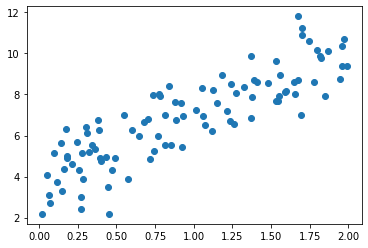

In [122]:
X = 2*np.random.rand(100,1)
X_aug = np.c_[X, np.ones(len(X))]

theta = np.array([3,4])
y = X_aug.dot(theta) + np.random.normal(size=(X.shape[0]))
plt.scatter(X[:,0], y)

Solve using the normal equation

In [138]:
theta_hat = np.linalg.inv(X_aug.T.dot(X_aug)).dot(X_aug.T).dot(y)
theta_hat

array([3.14102158, 3.86448297])

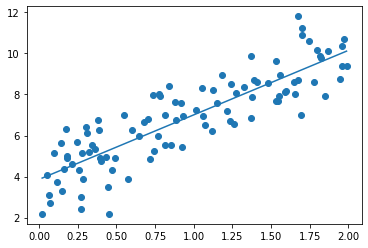

In [124]:
plt.scatter(X[:,0], y)
plt.plot([min(X), max(X)], theta_hat.dot(np.c_[[min(X), 1], [max(X), 1]]))

Solve using sklearn...

In [125]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.coef_, lin_reg.intercept_

(array([3.14102158]), 3.8644829654467294)

...which uses numpy's least squares...

In [126]:
svd, residuals, rank, s = np.linalg.lstsq(X_aug, y, rcond=1e-6)
svd

array([3.14102158, 3.86448297])

...which uses the Moore--Penrose inverse.

In [127]:
np.linalg.pinv(X_aug).dot(y)

array([3.14102158, 3.86448297])

Batch gradient descent:

In [149]:
eta = 0.005 # learning rate
max_iter = 1000

theta_hat = np.random.normal(size=X_aug.shape[1])
for i in range(max_iter):
    grad = 2/X_aug.shape[1] * X_aug.T.dot(X_aug.dot(theta_hat) - y)
    theta_hat = theta_hat - eta * grad

theta_hat

array([3.14102158, 3.86448297])